In [1]:
import numpy
import scipy.special
import scipy.interpolate
import scipy.integrate
from matplotlib import pyplot
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

# Cosine Potential Plot

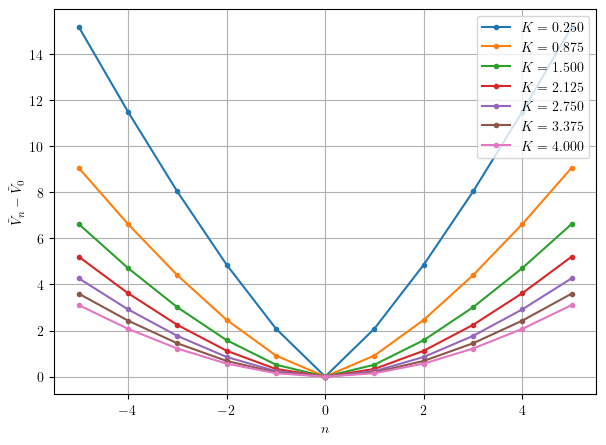

In [2]:
fig, ax = pyplot.subplots(figsize=(7,5))

for k in numpy.linspace(0.25,4,7):
    xs = numpy.arange(-5,5+1)
    offset = scipy.special.iv(0, k)
    pyplot.plot(xs, numpy.log(offset/scipy.special.iv(xs, k)), '.-', label=f"$K={k:.3f}$")
ax.grid()
ax.legend(loc="upper right")
ax.set_xlabel("$n$")
ax.set_ylabel(r"$\tilde{V}_{n} - \tilde{V}_0$")
pyplot.savefig("/tmp/cosine.pdf")
pyplot.show()

# Cosine Action Plot

In [3]:
# basedir = '../outputs/cosine/'

# data = {}


# for x in os.listdir(basedir):
#     lbase = os.path.join(basedir, x)
#     if os.path.isdir(lbase):
#         if x.startswith("L="):
#             L = int(x[2:])
#         else:
#             continue
        
#         all_ks = []
#         all_actions = []

#         mean_points = []
#         for x in os.listdir(lbase):
#             if x.endswith('.npz'):
#                 arr = numpy.load(os.path.join(lbase, x))
                
#                 if 'energies' in arr:
#                     x = arr['energies']
#                 elif 'actions' in arr:
#                     x = arr['actions']
#                 ks = 1.0/arr['ks']

#                 for (k, xx) in zip(ks, x.T):
#                     xxx = xx - xx.mean()

#                     binder = 1.0 - (xxx**4).mean() / (3 * ((xxx**2).mean()**2))
#                     mean_points.append((k, xx.mean() / (L**4), xx.var() / (L**4), binder))
#                     all_ks.extend([k]*len(xx))
#                     all_actions.extend(xx / (L**4))
                    
#         unique_ks, mean_actions, std_actions, binder_actions = zip(*sorted(mean_points, key=lambda x: x[0]))
#         data[L] = (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions)

In [4]:
basedir = '../outputs/cosine/'

data = {}


for x in os.listdir(basedir):
    lbase = os.path.join(basedir, x)
    if os.path.isdir(lbase):
        if x.startswith("L="):
            L = int(x[2:])
        else:
            continue
        
        all_ks = []
        all_actions = []

        mean_points_acc = {}
        for x in os.listdir(lbase):
            if x.endswith('.npz'):
                arr = numpy.load(os.path.join(lbase, x))
                
                if 'energies' in arr:
                    x = arr['energies']
                elif 'actions' in arr:
                    x = arr['actions']
                ks = 1.0/arr['ks']

                for (k, xx) in zip(ks, x.T):
                    if k not in mean_points_acc:
                        mean_points_acc[k] = []
                    mean_points_acc[k].append(xx)
        
        mean_points = []
        for k, xxs in mean_points_acc.items():
            xx = numpy.concatenate(xxs)
            # print(xxs.shape)
            xxx = xx - xx.mean()

            binder = 1.0 - (xxx**4).mean() / (3 * ((xxx**2).mean()**2))
            mean_points.append((k, xx.mean() / (L**4), xx.var() / (L**4), binder))
            all_ks.extend([k]*len(xx))
            all_actions.extend(xx / (L**4))
                    
        unique_ks, mean_actions, std_actions, binder_actions = zip(*sorted(mean_points, key=lambda x: x[0]))
        data[L] = (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions)

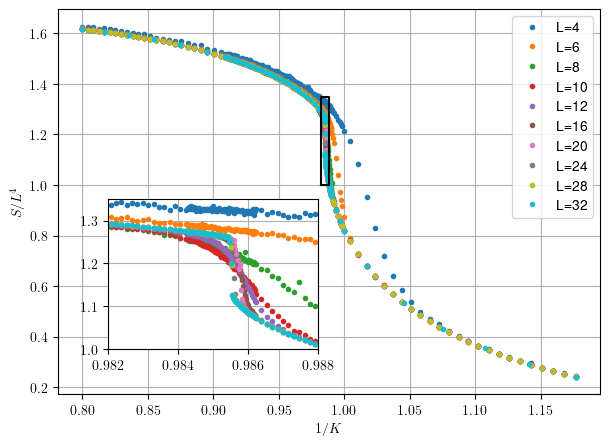

In [5]:
inv_kmin = 0.982
inv_kmax = 0.988
smin = 1.0
smax = 1.35


fig, ax1 = pyplot.subplots(figsize=(7,5))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2-0.003, 0.2, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
    ax1.plot(unique_ks, mean_actions, '.', label=f'L={L}')
ax1.plot([inv_kmin, inv_kmax, inv_kmax, inv_kmin, inv_kmin], [smin, smin, smax, smax, smin], c='black')
ax1.grid()
ax1.legend()

for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
    ax2.plot(unique_ks, mean_actions, '.', label=f'L={L}')
ax2.set_xlim((inv_kmin, inv_kmax))
ax2.set_ylim((smin, smax))
ax2.grid()

ax1.set_ylabel(r"$S/L^4$")
ax1.set_xlabel(r"$1/K$")

pyplot.savefig("paper_plots/cosine_action.pdf")
pyplot.show()

/var/folders/xx/cyn56y8j4l198w4cbbcv3pp80000gn/T/ipykernel_9705/4287135473.py:31: RuntimeWarning: divide by zero encountered in log
  axs[1].imshow(numpy.log(arr.T), interpolation='none', extent=[inv_kmin, inv_kmax,smin,smax], origin='lower')


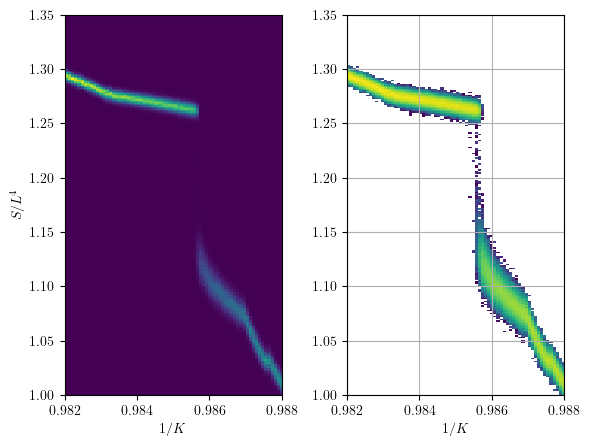

In [8]:
for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
    if L != 32:
        continue
    ndigits = 128
    
    ks_digits = numpy.digitize(all_ks, numpy.linspace(inv_kmin,inv_kmax, ndigits))

    kd_bins = {}

    for kd, action in zip(ks_digits, all_actions):
        if kd == 0 or kd == ndigits:
            continue
        if kd not in kd_bins:
            kd_bins[kd] = []
        kd_bins[kd].append(action)

    arr = []

    for kd in sorted(kd_bins.keys()):
        actions = kd_bins[kd]
        hist_actions, _ = numpy.histogram(actions, bins=numpy.linspace(smin,smax,256), density=True)
        hist_actions = hist_actions / sum(hist_actions)
        arr.append(hist_actions)
    arr = numpy.array(arr)
    
    fig, axs = pyplot.subplots(1, 2, figsize=(6,6))
    
    axs[0].imshow(arr.T, interpolation='none', extent=[inv_kmin, inv_kmax,smin,smax], origin='lower')
    axs[0].set_aspect(0.03)

    axs[1].imshow(numpy.log(arr.T), interpolation='none', extent=[inv_kmin, inv_kmax,smin,smax], origin='lower')
    axs[1].set_aspect(0.03)
    axs[1].grid()

    axs[0].set_ylabel("$S/L^4$")
    axs[0].set_xlabel("$1/K$")
    axs[1].set_xlabel("$1/K$")
    
    pyplot.tight_layout()
    pyplot.show()

In [9]:
# for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
#     if L != 32:
#         continue
#     ndigits = 128
    
#     ks_digits = numpy.digitize(all_ks, numpy.linspace(inv_kmin,inv_kmax, ndigits))

#     kd_bins = {}

#     for kd, action in zip(ks_digits, all_actions):
#         if kd == 0 or kd == ndigits:
#             continue
#         if kd not in kd_bins:
#             kd_bins[kd] = []
#         kd_bins[kd].append(action)

#     arr = []

#     for kd in sorted(kd_bins.keys()):
#         actions = kd_bins[kd]
#         hist_actions, _ = numpy.histogram(actions, bins=numpy.linspace(s_min,s_max,256), density=True)
#         hist_actions = hist_actions / sum(hist_actions)
#         arr.append(hist_actions)
#     arr = numpy.array(arr)
    
#     # ax.imshow(arr.T, interpolation='none', extent=[inv_kmin, inv_kmax,s_min,s_max], origin='lower')
#     # axs[0].set_aspect(0.03)

#     fig, ax = pyplot.subplots(figsize=(10,5))
#     # cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
#     cax = fig.add_axes([0.7,0.11,0.02,0.77])
    
#     im = ax.imshow(numpy.log(arr.T), interpolation='none', extent=[inv_kmin, inv_kmax,s_min,s_max], origin='lower', aspect=0.02)
#     # pyplot.set_aspect(0.03)
#     ax.grid()

#     ax.set_ylabel("$S/L^4$")
#     ax.set_xlabel("$1/K$")
    
#     fig.colorbar(im, cax=cax, orientation='vertical', label="Log Probability")

#     # ax.plot(unique_ks, mean_actions, '-', c="r", label=f'L={L}')
#     # ax.set_xlim((inv_kmin, inv_kmax))
#     # ax.set_ylim((inv_kmin, inv_kmax))
    
#     pyplot.savefig("paper_plots/cosine_action_density.pdf",bbox_inches='tight')
#     pyplot.show()

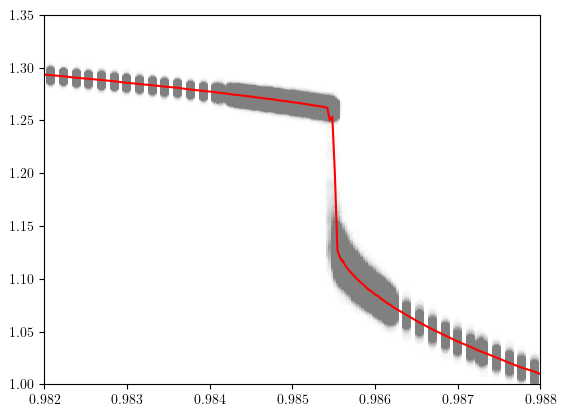

In [12]:
for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
    if L != 32:
        continue
    pyplot.plot(unique_ks, mean_actions, '-', c="r", label=f'L={L}')
    pyplot.scatter(all_ks, all_actions, c='gray', alpha=0.004)
    pyplot.xlim((inv_kmin, inv_kmax))
    pyplot.ylim((smin, smax))

/Users/sumner/.pyenv/versions/3.11.2/envs/gaugemc/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/xx/cyn56y8j4l198w4cbbcv3pp80000gn/T/ipykernel_9705/3153563907.py:30: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(numpy.log(arr.T), interpolation='none', extent=[inv_kmin, inv_kmax,smin,smax], origin='lower', aspect=0.02)


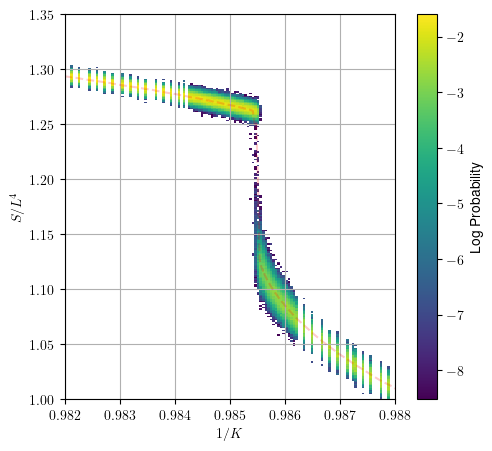

In [14]:
for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
    if L != 32:
        continue
    ndigits = 128
    
    ks_digits = numpy.digitize(all_ks, numpy.linspace(inv_kmin,inv_kmax, ndigits))

    kd_bins = [list() for _ in range(ndigits+1)]
    for k, kd, action in zip(all_ks, ks_digits, all_actions):
        if k < inv_kmin or k >= inv_kmax:
            continue
        kd_bins[kd].append(action)

    arr = []

    for kd in range(ndigits+1):
        actions = kd_bins[kd]
        hist_actions, _ = numpy.histogram(actions, bins=numpy.linspace(smin,smax,256), density=True)
        hist_actions = hist_actions / sum(hist_actions)
        arr.append(hist_actions)
    arr = numpy.array(arr)
    
    # ax.imshow(arr.T, interpolation='none', extent=[inv_kmin, inv_kmax,s_min,s_max], origin='lower')
    # axs[0].set_aspect(0.03)

    fig, ax = pyplot.subplots(figsize=(10,5))
    # cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
    cax = fig.add_axes([0.7,0.11,0.02,0.77])
    
    im = ax.imshow(numpy.log(arr.T), interpolation='none', extent=[inv_kmin, inv_kmax,smin,smax], origin='lower', aspect=0.02)
    # pyplot.set_aspect(0.03)
    ax.grid()

    ax.set_ylabel("$S/L^4$")
    ax.set_xlabel("$1/K$")
    
    fig.colorbar(im, cax=cax, orientation='vertical', label="Log Probability")

    ax.plot(unique_ks, mean_actions, '--', c="r", label=f'L={L}', alpha=0.2)
    ax.set_xlim((inv_kmin, inv_kmax))
    ax.set_ylim((smin, smax))
    
    pyplot.savefig("paper_plots/cosine_action_density.pdf",bbox_inches='tight')
    pyplot.show()

# Cosine Specific Heat

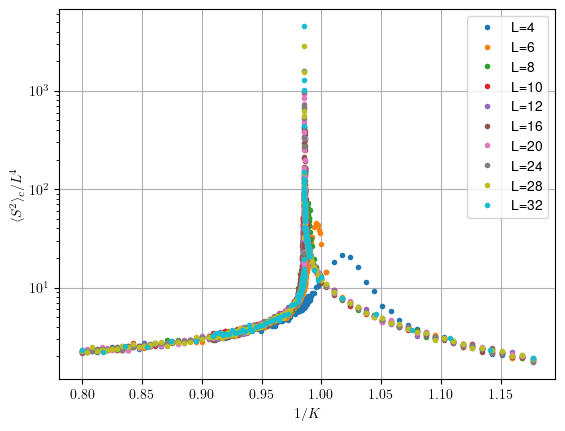

In [15]:
for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
    pyplot.plot(unique_ks, std_actions, '.', label=f'L={L}')
pyplot.grid()
pyplot.yscale('log')
pyplot.xlabel("$1/K$")
pyplot.ylabel(r"$\langle S^2 \rangle_c / L^4$")
pyplot.legend()
pyplot.savefig("paper_plots/cosine_specificheat.pdf",bbox_inches='tight')
pyplot.show()

In [ ]:
ls = []
maxks = []
for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
    unique_ks[numpy.argmax(std_actions)]
    pyplot.plot(unique_ks, std_actions, '.', label=f'L={L}')
pyplot.grid()
pyplot.yscale('log')
pyplot.xlabel("$1/K$")
pyplot.ylabel(r"$\langle S^2 \rangle_c / L^4$")
pyplot.legend()
pyplot.savefig("paper_plots/cosine_specificheat.pdf",bbox_inches='tight')
pyplot.show()

# Cosine Latent Heat

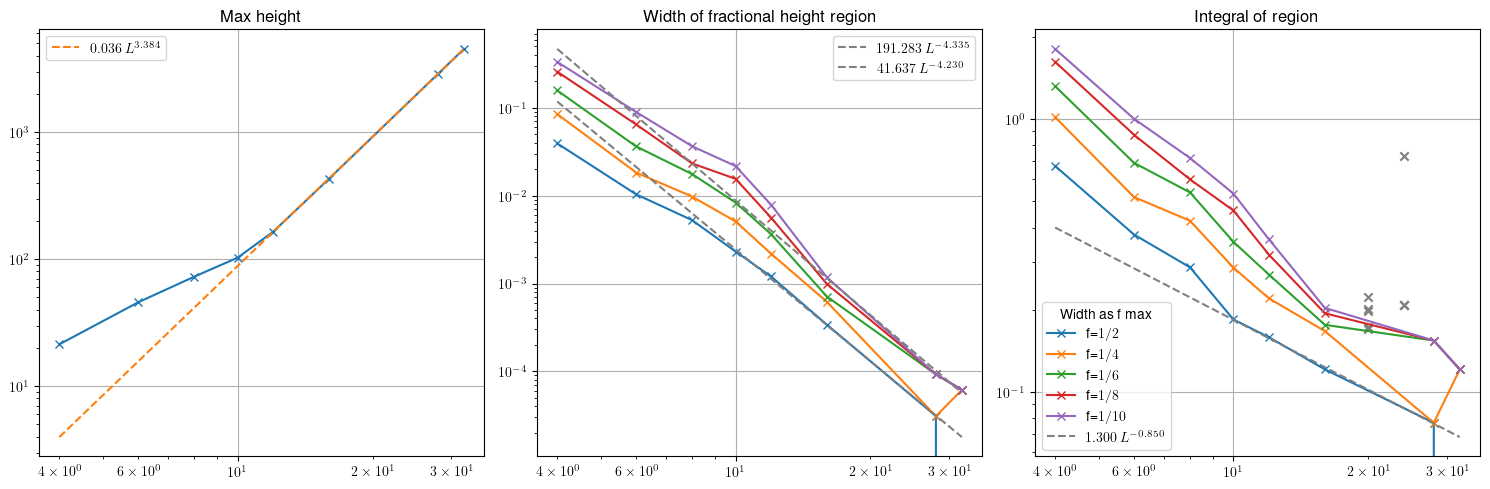

-0.9513694945221731 -0.8463166714124561


In [16]:
fig, axs = pyplot.subplots(1,3, figsize=(15,5))

l_ls = {}
l_heights = {}
l_widths = {}
l_integrals = {}

rejects_ls = []
rejects_ints = []
for i in range(2,10+1,2):
    ls = []
    heights = []
    widths = []
    integrals = []
    for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
        inter = scipy.interpolate.InterpolatedUnivariateSpline(unique_ks, std_actions)
        unique_ks = numpy.array(unique_ks)
        max_std_act = numpy.max(std_actions)
        half_max = max_std_act / float(i)
        above_half_mask = std_actions >= half_max
        lowest_extent = numpy.min(unique_ks[above_half_mask])
        largest_extent = numpy.max(unique_ks[above_half_mask])
        width = largest_extent - lowest_extent
        integral = inter.integral(lowest_extent, largest_extent)
        if L == 24 or L==20:
            rejects_ls.append(L)
            rejects_ints.append(integral)
        else:
            ls.append(L)
            heights.append(max_std_act)
            widths.append(width)
            integrals.append(integral)
    ls = numpy.array(ls)
    heights = numpy.array(heights)
    widths = numpy.array(widths)
    integrals = numpy.array(integrals)

    l_ls[i] = ls
    l_heights[i] = heights
    l_widths[i] = widths
    l_integrals[i] = integrals

for i in l_ls.keys():
    ls = l_ls[i]
    widths = l_widths[i]
    integrals = l_integrals[i]
    axs[1].plot(ls, widths, 'x-')
    axs[2].plot(ls, integrals, 'x-', label=f"f=$1/{i}$")

reg = scipy.stats.linregress(numpy.log(ls[4:]), numpy.log(heights[4:]))
axs[0].plot(ls, heights, 'x-')
axs[0].plot(ls, numpy.exp(reg.slope*numpy.log(ls) + reg.intercept), '--', label="${:.3f}~L^{{ {:.3f} }}$".format(numpy.exp(reg.intercept), reg.slope))
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_title("Max height")


reg1 = scipy.stats.linregress(numpy.log(ls[5:]), numpy.log(widths[5:]))
axs[1].plot(ls, numpy.exp(reg1.slope*numpy.log(ls) + reg1.intercept), '--', c='gray', label="${:.3f}~L^{{ {:.3f} }}$".format(numpy.exp(reg1.intercept), reg1.slope))
ls, widths = l_ls[2], l_widths[2]
reg2 = scipy.stats.linregress(numpy.log(ls[3:-1]), numpy.log(widths[3:-1]))
axs[1].plot(ls, numpy.exp(reg2.slope*numpy.log(ls) + reg2.intercept), '--', c='gray', label="${:.3f}~L^{{ {:.3f} }}$".format(numpy.exp(reg2.intercept), reg2.slope))

axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].legend()
axs[1].set_title("Width of fractional height region")


ls, integrals = l_ls[2], l_integrals[2]
reg3 = scipy.stats.linregress(numpy.log(ls[3:-1]), numpy.log(integrals[3:-1]))
axs[2].plot(ls, numpy.exp(reg3.slope*numpy.log(ls) + reg3.intercept), '--', c='gray', label="${:.3f}~L^{{ {:.3f} }}$".format(numpy.exp(reg3.intercept), reg3.slope))

axs[2].scatter(rejects_ls, rejects_ints, marker='x', c='gray')
axs[2].set_title("Integral of region")
axs[2].set_yscale('log')
axs[2].set_xscale('log')

axs[0].grid()
axs[1].grid()
axs[2].grid()
pyplot.tight_layout()
pyplot.legend(title="Width as f max")
pyplot.show()

print(reg.slope + reg1.slope, reg.slope + reg2.slope)

# Cosine Sliding Window Jumps

In [ ]:
for L, (_, _, unique_ks, mean_actions, _, _) in sorted(data.items()):
    volume = L**4
    unique_ks = list(unique_ks)
    mean_actions = list(mean_actions)

    # tck_s = scipy.interpolate.splrep(*zip(*[(k,a) for k,a in sorted(zip(unique_ks, mean_actions))]), s=1e-3)
    # interp = scipy.interpolate.BSpline(*tck_s)
    interp = scipy.interpolate.interp1d(*zip(*[(k,a) for k,a in sorted(zip(unique_ks, mean_actions))]))
    
    ks = []
    deltas = []
    
    for k in numpy.linspace(0.85,1.1,4096):
        delta = interp(k-10.0/volume) - interp(k+10.0/volume)
        ks.append(k)
        deltas.append(delta*volume/20.0)
    pyplot.plot(ks, deltas)
pyplot.grid()
pyplot.yscale('log')
pyplot.show()

In [ ]:
for L, (_, _, unique_ks, mean_actions, _, _) in sorted(data.items()):
    volume = L**4
    unique_ks = list(unique_ks)
    mean_actions = list(mean_actions)

    mindiff = numpy.abs(numpy.diff(sorted(set(unique_ks)))).min()

    tck_s = scipy.interpolate.splrep(*zip(*[(k,a) for k,a in sorted(zip(unique_ks, mean_actions))]), s=0.001)
    interp = scipy.interpolate.BSpline(*tck_s)
    dinterp = interp.derivative()
    ks = numpy.linspace(0.85,1.1,4096)
    pyplot.plot(ks, -dinterp(ks), label=f'L={L}')
pyplot.grid()
pyplot.legend()
pyplot.yscale('log')
pyplot.show()

# Villain Potential

In [22]:
basedir = '../outputs/villain/'

data = {}


for x in os.listdir(basedir):
    lbase = os.path.join(basedir, x)
    if os.path.isdir(lbase):
        if x.startswith("L="):
            L = int(x[2:])
        else:
            continue
        
        all_ks = []
        all_actions = []

        mean_points_acc = {}
        for x in os.listdir(lbase):
            if x.endswith('.npz'):
                arr = numpy.load(os.path.join(lbase, x))
                
                if 'energies' in arr:
                    x = arr['energies']
                elif 'actions' in arr:
                    x = arr['actions']
                ks = arr['ks']

                for (k, xx) in zip(ks, x.T):
                    if k not in mean_points_acc:
                        mean_points_acc[k] = []
                    mean_points_acc[k].append(xx)
        
        mean_points = []
        for k, xxs in mean_points_acc.items():
            xx = numpy.concatenate(xxs)
            # print(xxs.shape)
            xxx = xx - xx.mean()

            binder = 1.0 - (xxx**4).mean() / (3 * ((xxx**2).mean()**2))
            mean_points.append((k, xx.mean() / (L**4), xx.var() / (L**4), binder))
            all_ks.extend([k]*len(xx))
            all_actions.extend(xx / (L**4))
                    
        unique_ks, mean_actions, std_actions, binder_actions = zip(*sorted(mean_points, key=lambda x: x[0]))
        data[L] = (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions)

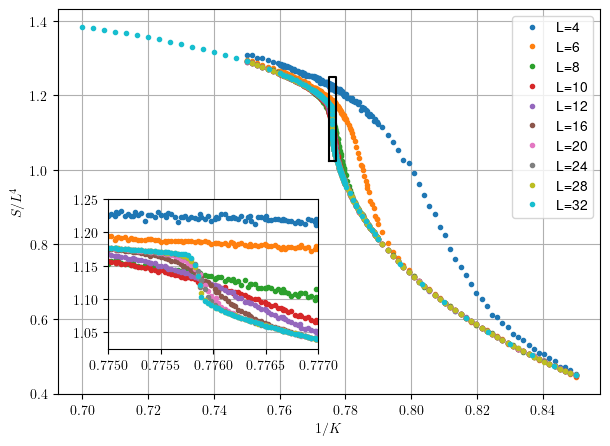

In [55]:
inv_kmin = 0.775
inv_kmax = 0.777
smin = 1.025
smax = 1.25


fig, ax1 = pyplot.subplots(figsize=(7,5))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2-0.003, 0.2, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
    ax1.plot(unique_ks, mean_actions, '.', label=f'L={L}')
ax1.plot([inv_kmin, inv_kmax, inv_kmax, inv_kmin, inv_kmin], [smin, smin, smax, smax, smin], c='black')
ax1.grid()
ax1.legend()

for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
    ax2.plot(unique_ks, mean_actions, '.', label=f'L={L}')
ax2.set_xlim((inv_kmin, inv_kmax))
ax2.set_ylim((smin, smax))
ax2.grid()

ax1.set_ylabel(r"$S/L^4$")
ax1.set_xlabel(r"$1/K$")

pyplot.savefig("paper_plots/villain_action.pdf")
pyplot.show()

/var/folders/xx/cyn56y8j4l198w4cbbcv3pp80000gn/T/ipykernel_9705/1065804463.py:30: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(numpy.log(arr.T), interpolation='none', extent=[inv_kmin, inv_kmax,smin,smax], origin='lower', aspect=0.01)


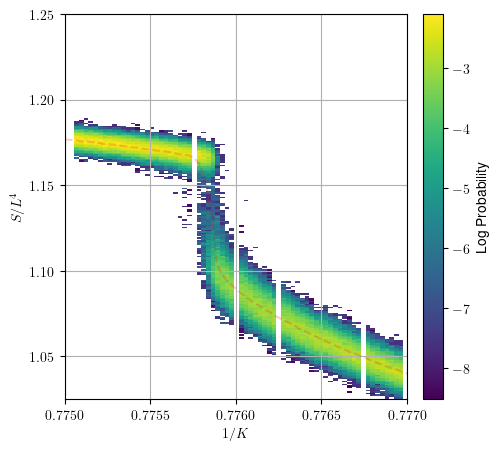

In [58]:
for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
    if L != 32:
        continue
    ndigits = 72
    
    ks_digits = numpy.digitize(all_ks, numpy.linspace(inv_kmin,inv_kmax, ndigits))

    kd_bins = [list() for _ in range(ndigits+1)]
    for k, kd, action in zip(all_ks, ks_digits, all_actions):
        if k < inv_kmin or k >= inv_kmax:
            continue
        kd_bins[kd].append(action)

    arr = []

    for kd in range(ndigits+1):
        actions = kd_bins[kd]
        hist_actions, _ = numpy.histogram(actions, bins=numpy.linspace(smin,smax,256), density=True)
        hist_actions = hist_actions / sum(hist_actions)
        arr.append(hist_actions)
    arr = numpy.array(arr)
    
    # ax.imshow(arr.T, interpolation='none', extent=[inv_kmin, inv_kmax,s_min,s_max], origin='lower')
    # axs[0].set_aspect(0.03)

    fig, ax = pyplot.subplots(figsize=(10,5))
    # cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
    cax = fig.add_axes([0.7,0.11,0.02,0.77])
    
    im = ax.imshow(numpy.log(arr.T), interpolation='none', extent=[inv_kmin, inv_kmax,smin,smax], origin='lower', aspect=0.01)
    # pyplot.set_aspect(0.03)
    ax.grid()

    ax.set_ylabel("$S/L^4$")
    ax.set_xlabel("$1/K$")
    
    fig.colorbar(im, cax=cax, orientation='vertical', label="Log Probability")

    ax.plot(unique_ks, mean_actions, '--', c="r", label=f'L={L}', alpha=0.2)
    ax.set_xlim((inv_kmin, inv_kmax))
    ax.set_ylim((smin, smax))
    
    pyplot.savefig("paper_plots/villain_action_density.pdf",bbox_inches='tight')
    pyplot.show()

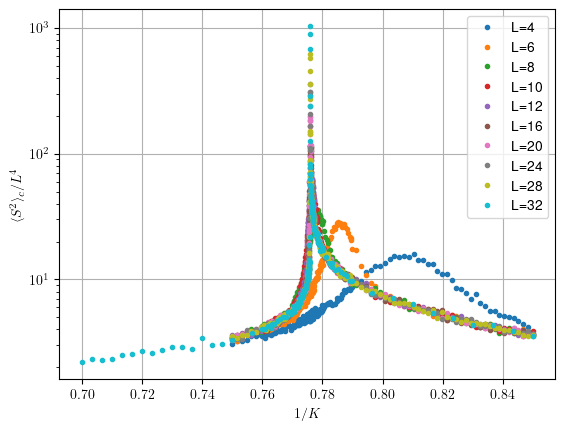

In [59]:
for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
    pyplot.plot(unique_ks, std_actions, '.', label=f'L={L}')
pyplot.grid()
pyplot.yscale('log')
pyplot.xlabel("$1/K$")
pyplot.ylabel(r"$\langle S^2 \rangle_c / L^4$")
pyplot.legend()
pyplot.savefig("paper_plots/villain_specificheat.pdf",bbox_inches='tight')
pyplot.show()

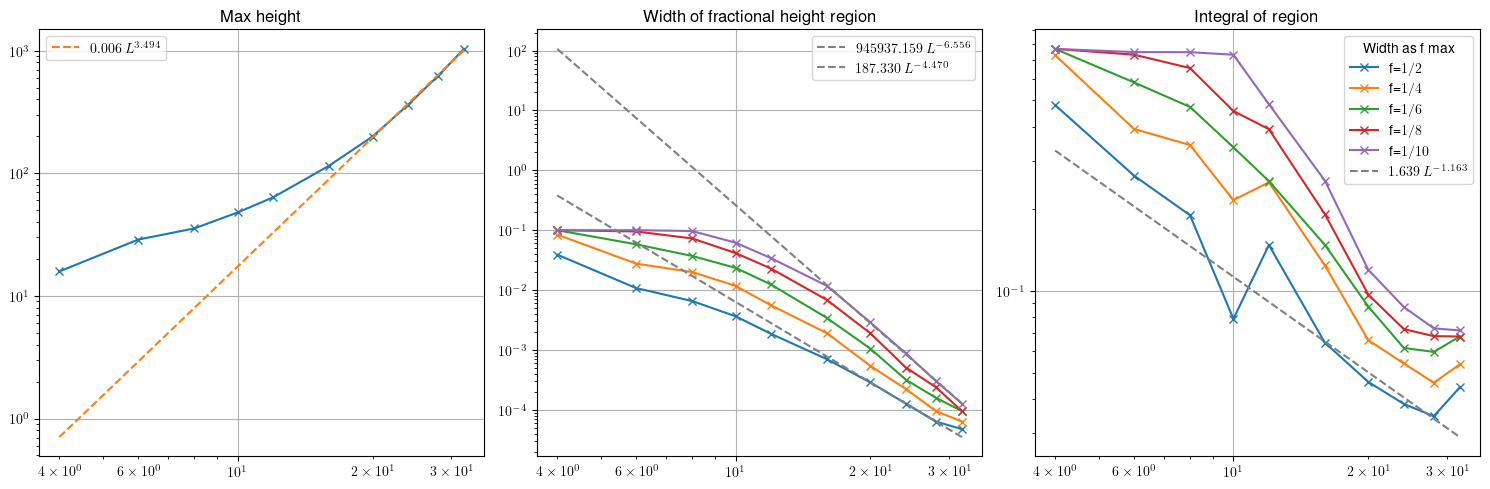

-3.061665943446227 -0.9761537030212124


In [67]:
fig, axs = pyplot.subplots(1,3, figsize=(15,5))

l_ls = {}
l_heights = {}
l_widths = {}
l_integrals = {}

rejects_ls = []
rejects_ints = []
for i in range(2,10+1,2):
    ls = []
    heights = []
    widths = []
    integrals = []
    for L, (all_ks, all_actions, unique_ks, mean_actions, std_actions, binder_actions) in sorted(data.items()):
        inter = scipy.interpolate.InterpolatedUnivariateSpline(unique_ks, std_actions)
        unique_ks = numpy.array(unique_ks)
        max_std_act = numpy.max(std_actions)
        half_max = max_std_act / float(i)
        above_half_mask = std_actions >= half_max
        lowest_extent = numpy.min(unique_ks[above_half_mask])
        largest_extent = numpy.max(unique_ks[above_half_mask])
        width = largest_extent - lowest_extent
        integral = inter.integral(lowest_extent, largest_extent)
        if False: #L == 24 or L==20:
            rejects_ls.append(L)
            rejects_ints.append(integral)
        else:
            ls.append(L)
            heights.append(max_std_act)
            widths.append(width)
            integrals.append(integral)
    ls = numpy.array(ls)
    heights = numpy.array(heights)
    widths = numpy.array(widths)
    integrals = numpy.array(integrals)

    l_ls[i] = ls
    l_heights[i] = heights
    l_widths[i] = widths
    l_integrals[i] = integrals

for i in l_ls.keys():
    ls = l_ls[i]
    widths = l_widths[i]
    integrals = l_integrals[i]
    axs[1].plot(ls, widths, 'x-')
    axs[2].plot(ls, integrals, 'x-', label=f"f=$1/{i}$")

reg = scipy.stats.linregress(numpy.log(ls[-4:]), numpy.log(heights[-4:]))
axs[0].plot(ls, heights, 'x-')
axs[0].plot(ls, numpy.exp(reg.slope*numpy.log(ls) + reg.intercept), '--', label="${:.3f}~L^{{ {:.3f} }}$".format(numpy.exp(reg.intercept), reg.slope))
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_title("Max height")


reg1 = scipy.stats.linregress(numpy.log(ls[5:]), numpy.log(widths[5:]))
axs[1].plot(ls, numpy.exp(reg1.slope*numpy.log(ls) + reg1.intercept), '--', c='gray', label="${:.3f}~L^{{ {:.3f} }}$".format(numpy.exp(reg1.intercept), reg1.slope))
ls, widths = l_ls[2], l_widths[2]
reg2 = scipy.stats.linregress(numpy.log(ls[-4:-1]), numpy.log(widths[-4:-1]))
axs[1].plot(ls, numpy.exp(reg2.slope*numpy.log(ls) + reg2.intercept), '--', c='gray', label="${:.3f}~L^{{ {:.3f} }}$".format(numpy.exp(reg2.intercept), reg2.slope))

axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].legend()
axs[1].set_title("Width of fractional height region")


ls, integrals = l_ls[2], l_integrals[2]
reg3 = scipy.stats.linregress(numpy.log(ls[3:-1]), numpy.log(integrals[3:-1]))
axs[2].plot(ls, numpy.exp(reg3.slope*numpy.log(ls) + reg3.intercept), '--', c='gray', label="${:.3f}~L^{{ {:.3f} }}$".format(numpy.exp(reg3.intercept), reg3.slope))

axs[2].scatter(rejects_ls, rejects_ints, marker='x', c='gray')
axs[2].set_title("Integral of region")
axs[2].set_yscale('log')
axs[2].set_xscale('log')

axs[0].grid()
axs[1].grid()
axs[2].grid()
pyplot.tight_layout()
pyplot.legend(title="Width as f max")
pyplot.show()

print(reg.slope + reg1.slope, reg.slope + reg2.slope)